#  Решение задачи регрессии при помощи пакета `torch`. Метрики.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://github.com/Lightning-AI/torchmetrics
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://pytorch-lightning.readthedocs.io/en/2.1.2/pytorch/ecosystem/metrics.html#torchmetrics

## Задачи для совместного разбора

In [1]:
import torch as th

1\. Используя реализацию из `torch.nn`, решите задачу регрессии. Для расчета градиентов воспользуйтесь возможностями по автоматическому дифференцированию `torch`. В качестве функции потерь используйте собственную реализацию MSE. Для настройки весов реализуйте пакетный градиентный спуск с использованием `torch.optim.SGD`.

In [2]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y)


model = th.nn.Sequential(
    th.nn.Linear(4,16)
)

In [3]:
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_inputs: int, n_hidden:int, act = nn.ReLU()): #, n_outputs: int = 1, activation: ):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, n_hidden)
        self.act = act
        self.fc2 = nn.Linear(n_hidden, 1)
        
    
    def forward(self, X: th.Tensor) -> th.Tensor:
        # batch x n_inputs
        out = self.fc1(X) # batch x n_hidden
        out = self.act(out)
        # out = X.relu()
        # out = F.relu(out)
        out = self.fc2(out) # batch x 1
        return out
    
    



In [4]:
n_inputs = 4
n_hidden = 2
model = nn.Sequential(
        nn.Linear(n_inputs, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden,1)
)

In [5]:
y_pred = model(X)

In [6]:
y_pred.shape
y_pred

tensor([[-0.5967],
        [-0.5391],
        [-0.5307],
        [-0.5795],
        [-0.5178],
        [-0.4997],
        [-0.7661],
        [-0.8907],
        [-0.7079],
        [-0.5683],
        [-0.5343],
        [-0.6236],
        [-0.4997],
        [-0.4997],
        [-0.6691],
        [-0.5506],
        [-0.5574],
        [-0.4997],
        [-0.4997],
        [-0.6444],
        [-0.6588],
        [-0.4997],
        [-0.5831],
        [-0.6622],
        [-0.6647],
        [-0.5340],
        [-0.8555],
        [-0.4997],
        [-0.5308],
        [-0.5423],
        [-0.4997],
        [-0.4997],
        [-0.8069],
        [-0.4997],
        [-0.7810],
        [-0.6401],
        [-0.4997],
        [-0.5643],
        [-0.5182],
        [-0.6744],
        [-0.4997],
        [-0.5840],
        [-0.4997],
        [-0.5638],
        [-0.5935],
        [-0.5548],
        [-0.4997],
        [-0.5633],
        [-0.5654],
        [-0.4997],
        [-0.4997],
        [-0.5873],
        [-0.

In [7]:
criterion = nn.MSELoss()
loss = criterion(y_pred.flatten(), y)
loss

tensor(9577.7471, grad_fn=<MseLossBackward0>)

In [8]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr = 0.001)



In [9]:
model = Net(4,2)

y_pred = model(X).flatten()
loss = criterion(y_pred,y)
loss.backward()
optimizer.step()

optimizer.zero_grad()



## Задачи для самостоятельного решения

In [10]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.datasets import make_regression
import torch as th
import numpy as np
import time
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError,MeanSquaredLogError

<p class="task" id="1"></p>

1\. Используя реализацию полносвязного слоя из `torch.nn` решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Для создания модели опишите класс `SineModel`.

Предлагаемая архитектура нейронной сети: 
1. Полносвязный слой с 100 нейронами
2. Активация ReLU
3. Полносвязный слой с 1 нейроном

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).

Выведите график изменения значения функции потерь в процессе обучения. Логику расчета значения функции потерь на уровне эпохи реализуйте самостоятельно.

- [x] Проверено на семинаре

In [11]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size()) 

Отойдем от предложенной архитектуры нейронной сети:

1. Полносвязный слой с 16 нейронами
2. Активация ReLU
3. Полносвязный слой с 32 нейроном
4. Активация ReLU
5. Полносвязный слой с 1 нейроном


In [12]:
class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden1: int = 16, n_hidden2 :int = 32, n_out: int = 1) -> None:
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_hidden1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden2, n_out)
        
    
    def forward(self, X: th.Tensor) -> th.Tensor:
        # batch x n_features
        out = self.fc1(X) # batch x n_hidden1
        out = self.act1(out) # batch x n_hidden1
        out = self.fc2(out) # batch x n_hidden2
        out = self.act2(out) # batch x n_hidden2
        out = self.fc3(out) # batch x n_out

        return out

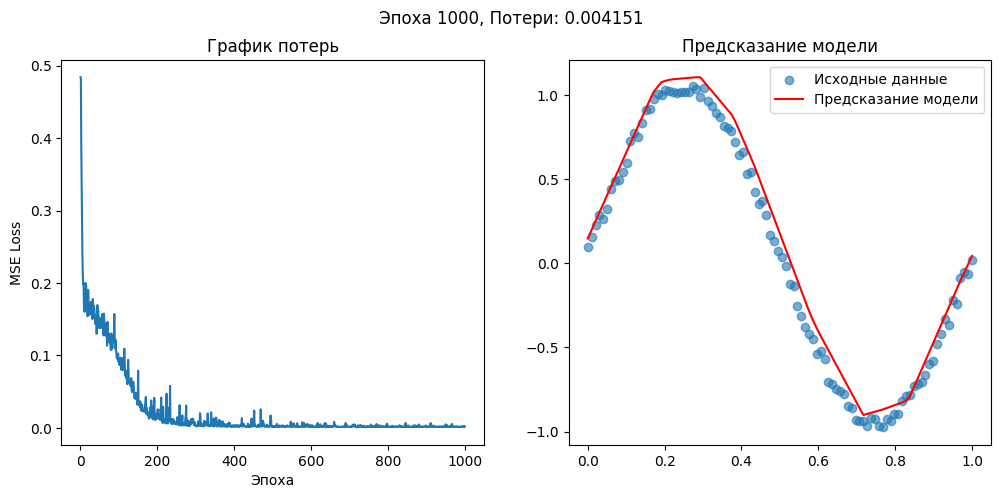

In [13]:
dset = TensorDataset(X,y)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = SineModel(X.shape[1], 16, 32)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.08)

EPOCHS = 1000
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch).flatten()
        loss = criterion(y_pred, y_batch.flatten())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
    #     print(f'epoch {epoch+1}, loss {e_loss}')
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("MSE Loss")

        ax2.scatter(X.numpy(), y.numpy(), label='Исходные данные', alpha=0.6)
        ax2.plot(X.numpy(), model(X).detach().numpy(), color='red', label='Предсказание модели')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {loss.item():.6f}")
        
        plt.show()
        

<p class="task" id="2"></p>

2\. Повторите решение задачи 1, изменив модель. Для создания модели создайте объект класса `nn.Sequential`.

Предлагаемая архитектура нейронной сети: 
1. Полносвязный слой с 50 нейронами
2. Активация Tanh
3. Полносвязный слой с 1 нейроном

- [x] Проверено на семинаре

In [14]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())

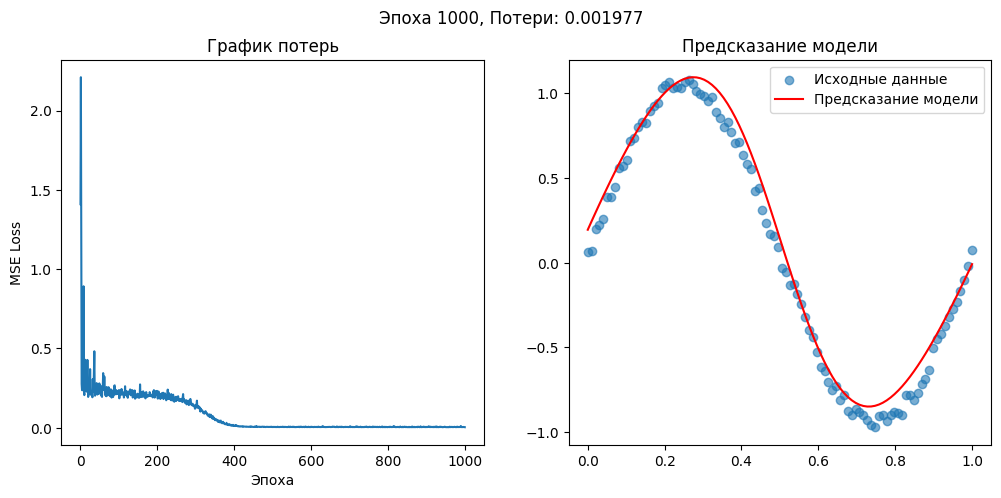

In [15]:
dset = TensorDataset(X,y)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = nn.Sequential(
    nn.Linear(X.shape[1],50),
    nn.Tanh(),
    nn.Linear(50, 1)
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.07)

EPOCHS = 1000
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch).flatten()
        loss = criterion(y_pred, y_batch.flatten())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
    #     print(f'epoch {epoch+1}, loss {e_loss}')
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("MSE Loss")

        ax2.scatter(X.numpy(), y.numpy(), label='Исходные данные', alpha=0.6)
        ax2.plot(X.numpy(), model(X).detach().numpy(), color='red', label='Предсказание модели')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {loss.item():.6f}")
        
        plt.show()

<p class="task" id="3"></p>

3\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Перенесите вычисления на GPU и сравните время обучения с и без использования GPU. Решение должно корректно работать в случае отсутствия GPU без дополнительных изменений в коде. 

- [x] Проверено на семинаре

In [16]:
X, y, coef = make_regression(
    n_samples=10000, 
    n_features=10, 
    n_informative=6, 
    coef=True, 
    bias=0.5, 
    random_state=42
)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [17]:
def run_training(device_name: str, model):
    if device_name=='cuda':
        if not torch.cuda.is_available():
            return 'cannot use cuda'
    device = torch.device(device_name)
    dset = TensorDataset(X, y)
    loader = DataLoader(dset, batch_size=512, shuffle=True)

    
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001) 
    losses = []
    start_time = time.time()
    for epoch in tqdm(range(EPOCHS), desc=f"Тренировка на {device.type.upper()}"):
        e_loss = 0
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        e_loss /= len(loader)
        losses.append(e_loss)
        if (epoch+1)%100==0:
            print(f'epoch {epoch+1:^5}, loss {e_loss:.8f}')
    
    end_time = time.time() - start_time
    print(f"Время тренировки на {device.type.upper()}: {end_time:.2f} секунд")
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

    ax1.plot(losses)
    ax1.set_title(f"График потерь {device_name}")
    ax1.set_xlabel("Эпоха")
    ax1.set_ylabel("Loss")

    fig.suptitle(f"Эпох {EPOCHS}\nПотери: {e_loss:.7f}\nВремя: {end_time} секунд", y=1.3)

    plt.show()
    return end_time

Тренировка на CPU:   0%|          | 0/200 [00:00<?, ?it/s]

epoch  100 , loss 0.00000000
epoch  200 , loss 0.00000000
Время тренировки на CPU: 49.89 секунд


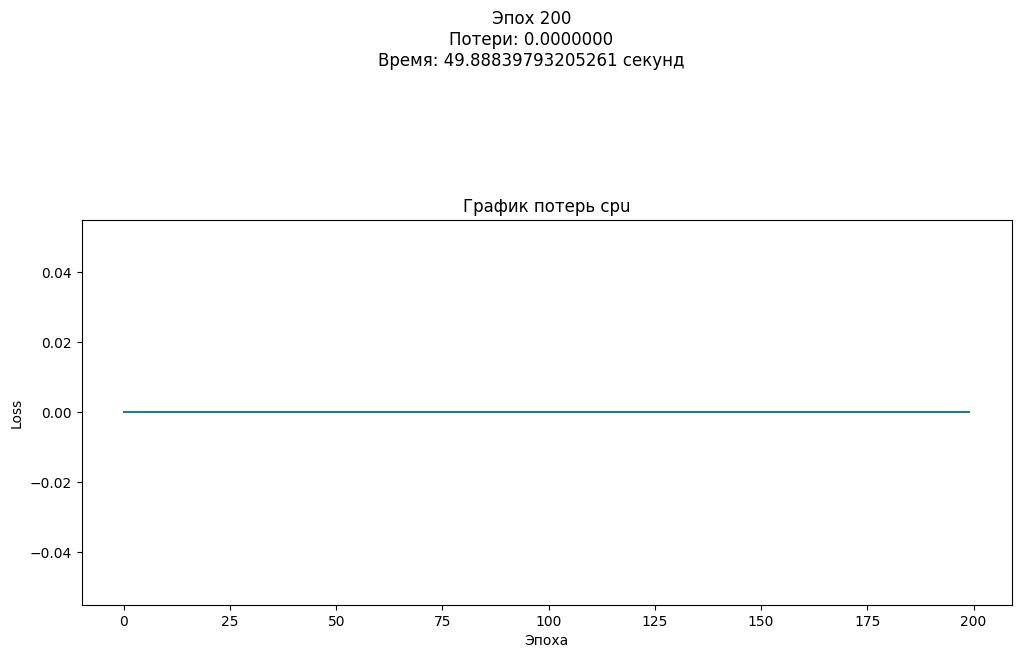

Тренировка на CUDA:   0%|          | 0/200 [00:00<?, ?it/s]

epoch  100 , loss 0.00000000
epoch  200 , loss 0.00000000
Время тренировки на CUDA: 27.31 секунд


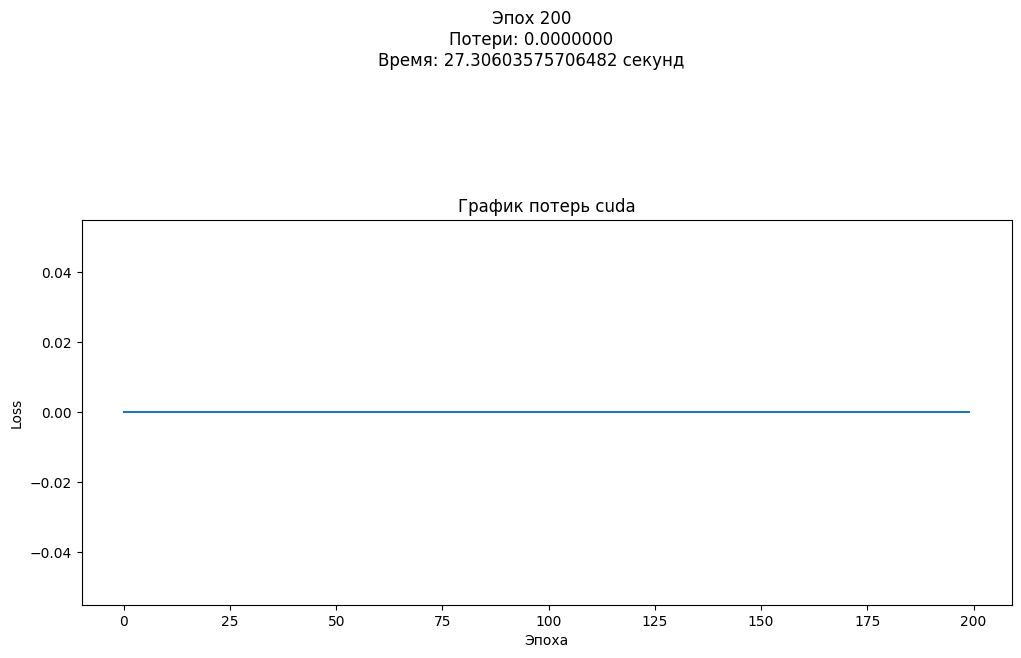

27.30603575706482

In [18]:
EPOCHS = 200
model = nn.Sequential(
    nn.Linear(X.shape[1], 512),
    nn.ReLU(),
    nn.Linear(512, 1024),       
    nn.ReLU(),
    nn.Linear(1024, 512),      
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 1)           
)
run_training('cpu',model)
run_training('cuda',model)

<p class="task" id="4"></p>

4\. Повторите решение задач 1-2, используя для расчета значения функции потерь за эпоху метрику `MeanMetric` из пакета `torchmetrics`. Добавьте в цикл обучения расчет метрики $R^2$ (воспользуйтесь реализацией из `torchmetrics`). Выведите на экран график изменения значения функции потерь и метрики $R^2$ по эпохам в процессе обучения.

In [19]:
from torchmetrics import MeanMetric
from torchmetrics.regression import R2Score

In [20]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())
dset = TensorDataset(X, y)
loader = DataLoader(dset, batch_size=16, shuffle=True)

epoch 0, MeanLoss: 0.555505, R2: -0.069784
epoch 100, MeanLoss: 0.044945, R2: 0.901286
epoch 200, MeanLoss: 0.013904, R2: 0.970316
epoch 300, MeanLoss: 0.008924, R2: 0.981232
epoch 400, MeanLoss: 0.003192, R2: 0.993626
epoch 500, MeanLoss: 0.001827, R2: 0.996511


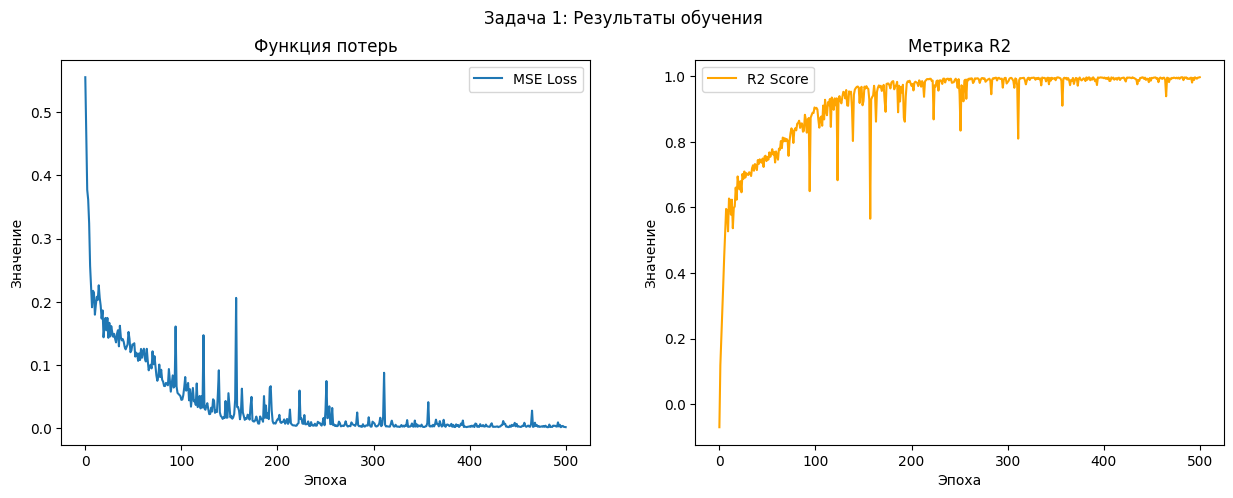

In [21]:
model1 = SineModel(X.shape[1], 16, 32)
criterion1 = nn.MSELoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.08)

EPOCHS = 500
epoch_losses1 = []
epoch_r2s1 = []
loss_metric1 = MeanMetric()
r2_metric1 = R2Score()

for epoch in range(EPOCHS + 1):
    loss_metric1.reset()
    r2_metric1.reset()

    for X_batch, y_batch in loader:
        y_pred = model1(X_batch).flatten()
        loss = criterion1(y_pred, y_batch.flatten())
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        loss_metric1.update(loss)
        r2_metric1.update(y_pred, y_batch.flatten())

    epoch_loss = loss_metric1.compute()
    epoch_r2 = r2_metric1.compute()
    epoch_losses1.append(epoch_loss.item())
    epoch_r2s1.append(epoch_r2.item())

    if epoch % 100 == 0:
        print(f'epoch {epoch}, MeanLoss: {epoch_loss:.6f}, R2: {epoch_r2:.6f}')

fig1, (aX_1, aX_2) = plt.subplots(1, 2, figsize=(15, 5))
fig1.suptitle('Задача 1: Результаты обучения')
aX_1.plot(epoch_losses1, label='MSE Loss')
aX_1.set_xlabel('Эпоха')
aX_1.set_ylabel('Значение')
aX_1.set_title('Функция потерь')
aX_1.legend()
aX_2.plot(epoch_r2s1, label='R2 Score', color='orange')
aX_2.set_xlabel('Эпоха')
aX_2.set_ylabel('Значение')
aX_2.set_title('Метрика R2')
aX_2.legend()
plt.show()

epoch 0, MeanLoss: 0.956336, R2: -0.641856
epoch 100, MeanLoss: 0.240447, R2: 0.519700
epoch 200, MeanLoss: 0.206608, R2: 0.572495
epoch 300, MeanLoss: 0.149823, R2: 0.686752
epoch 400, MeanLoss: 0.022612, R2: 0.953231
epoch 500, MeanLoss: 0.005863, R2: 0.989170


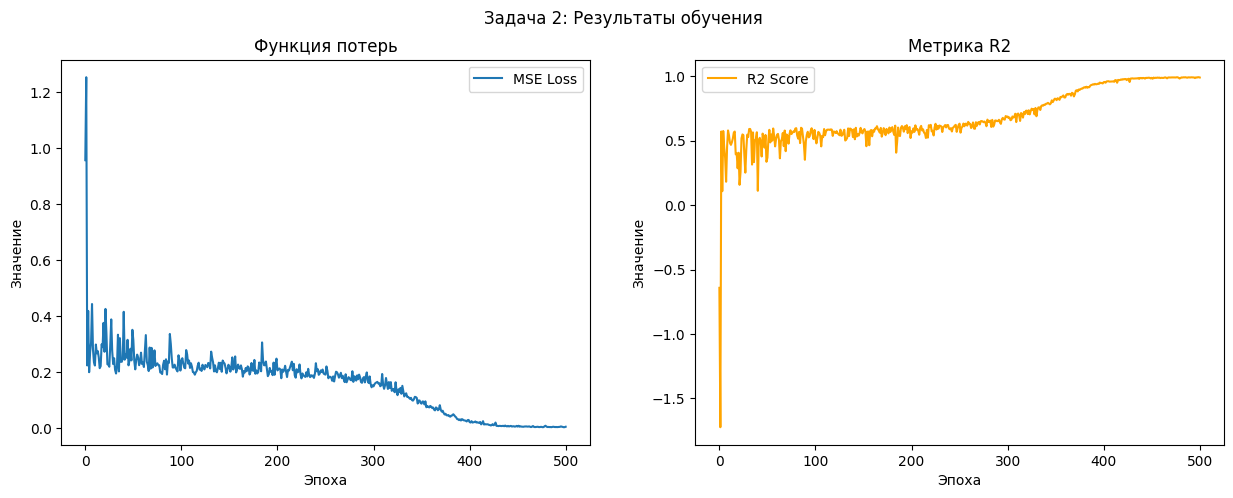

In [22]:
model2 = nn.Sequential(
    nn.Linear(X.shape[1], 50),
    nn.Tanh(),
    nn.Linear(50, 1)
)
criterion2 = nn.MSELoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.07)

EPOCHS = 500
epoch_losses2 = []
epoch_r2s2 = []
loss_metric2 = MeanMetric()
r2_metric2 = R2Score()

for epoch in range(EPOCHS + 1):
    loss_metric2.reset()
    r2_metric2.reset()

    for X_batch, y_batch in loader:
        y_pred = model2(X_batch).flatten()
        loss = criterion2(y_pred, y_batch.flatten())
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        loss_metric2.update(loss)
        r2_metric2.update(y_pred, y_batch.flatten())

    epoch_loss = loss_metric2.compute()
    epoch_r2 = r2_metric2.compute()
    epoch_losses2.append(epoch_loss.item())
    epoch_r2s2.append(epoch_r2.item())

    if epoch % 100 == 0:
        print(f'epoch {epoch}, MeanLoss: {epoch_loss:.6f}, R2: {epoch_r2:.6f}')

fig2, (aX_1, aX_2) = plt.subplots(1, 2, figsize=(15, 5))
fig2.suptitle('Задача 2: Результаты обучения')
aX_1.plot(epoch_losses2, label='MSE Loss')
aX_1.set_xlabel('Эпоха')
aX_1.set_ylabel('Значение')
aX_1.set_title('Функция потерь')
aX_1.legend()
aX_2.plot(epoch_r2s2, label='R2 Score', color='orange')
aX_2.set_xlabel('Эпоха')
aX_2.set_ylabel('Значение')
aX_2.set_title('Метрика R2')
aX_2.legend()
plt.show()

<p class="task" id="5"></p>

5\. Повторите решение задач 1-2, изменив функцию потерь. Обучите модель, используя три функции потерь: `MSELoss`, `L1Loss` и `HuberLoss` - и выведите на одном графике динамику изменения метрики $R^2$ по эпохам для каждой модели в процессе обучения. Добавьте подписи полученных кривых.

- [ ] Проверено на семинаре

In [23]:
def train_model(model, loader, criterion, optimizer, epochs=500):
    r2_metric = R2Score()
    r2_history = []

    for epoch in range(epochs):
        r2_metric.reset()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch).flatten()
            loss = criterion(y_pred, y_batch.flatten())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            r2_metric.update(y_pred.detach(), y_batch.flatten())
            
        epoch_r2 = r2_metric.compute().item()
        r2_history.append(epoch_r2)
        
    return r2_history

config

In [24]:
EPOCHS = 500
loss_functions = {
    'MSELoss': nn.MSELoss(),
    'L1Loss': nn.L1Loss(),
    'HuberLoss': nn.HuberLoss()
}

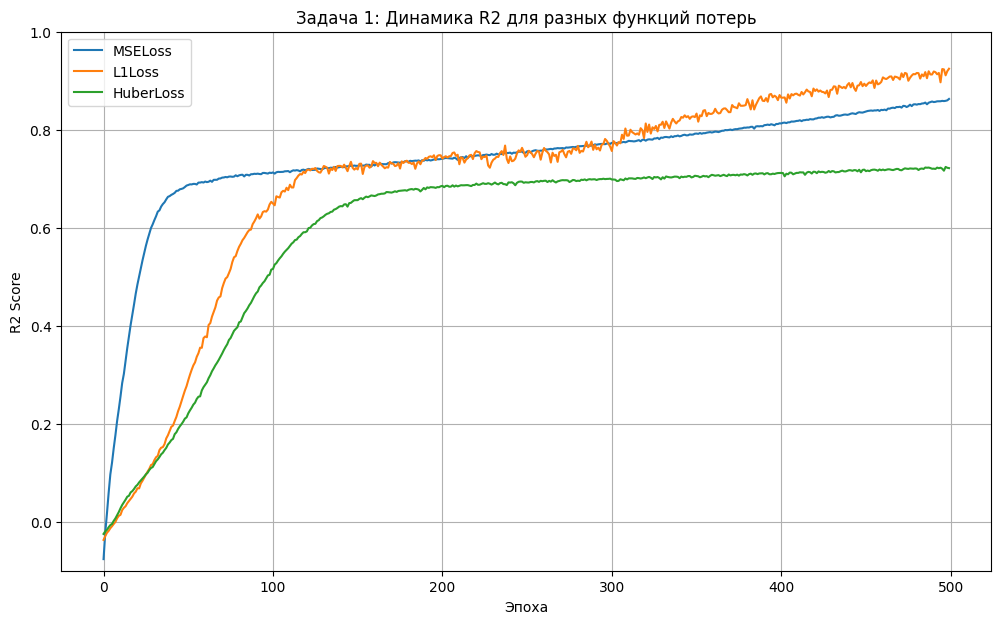

In [25]:
results1 = {}
for name, criterion in loss_functions.items():
    model = SineModel(X.shape[1], 16, 32)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    r2_history = train_model(model, loader, criterion, optimizer, epochs=EPOCHS)
    results1[name] = r2_history

plt.figure(figsize=(12, 7))
for name, history in results1.items():
    plt.plot(history, label=name)

plt.title('Задача 1: Динамика R2 для разных функций потерь')
plt.xlabel('Эпоха')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1)
plt.show()

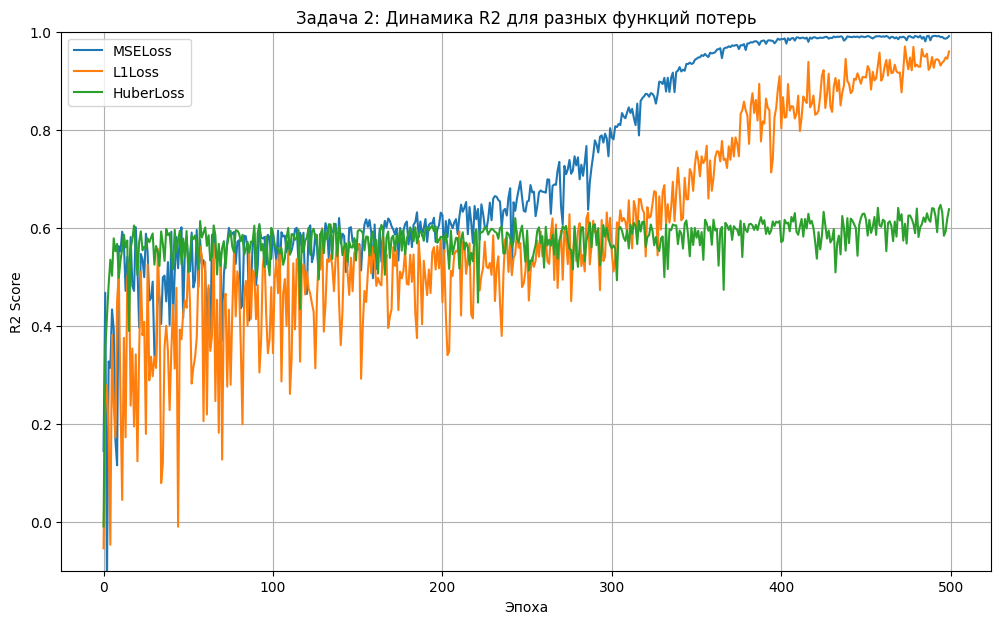

In [26]:
results2 = {}
for name, criterion in loss_functions.items():
    model = nn.Sequential(
        nn.Linear(X.shape[1], 50),
        nn.Tanh(),
        nn.Linear(50, 1)
    )
    optimizer = optim.SGD(model.parameters(), lr=0.07)
    
    r2_history = train_model(model, loader, criterion, optimizer, epochs=EPOCHS)
    results2[name] = r2_history

plt.figure(figsize=(12, 7))
for name, history in results2.items():
    plt.plot(history, label=name)

plt.title('Задача 2: Динамика R2 для разных функций потерь')
plt.xlabel('Эпоха')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1)
plt.show()

<p class="task" id="6"></p>

6\. Повторите решение задач 1-2, разделив датасет на обучающую и тестовую выборку в соотношении 80% на 20%. Обучите модель. Для тестовой выборки посчитайте и выведите на экран значения метрик:

- MAE;
- MAPE;
- MSE;
- MSLE (MeanSquaredLogError).
 

- [ ] Проверено на семинаре

In [27]:
train_size = int(X.shape[0]*0.8)
train_indices = np.random.choice(np.arange(X.shape[0]), train_size,False)
train_indices.sort()
test_indices = np.arange(X.shape[0])
test_indices[[i for i in test_indices if i not in train_indices]]
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

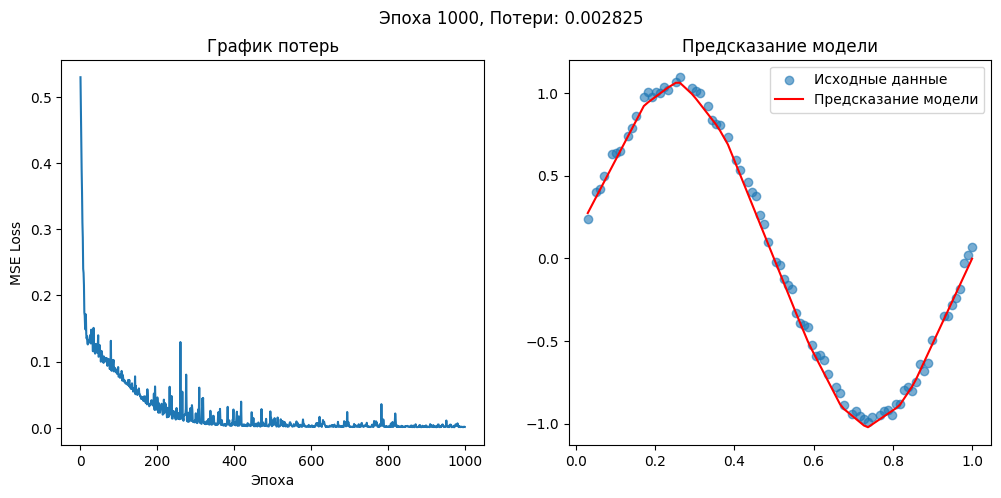

In [28]:
dset = TensorDataset(X_train,y_train)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = SineModel(X_train.shape[1], 16, 32)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.07)

EPOCHS = 1000
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_train_batch, y_train_batch in loader:
        y_train_pred = model(X_train_batch).flatten()
        loss = criterion(y_train_pred, y_train_batch.flatten())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
    #     print(f'epoch {epoch+1}, loss {e_loss}')
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("MSE Loss")

        ax2.scatter(X_train.numpy(), y_train.numpy(), label='Исходные данные', alpha=0.6)
        ax2.plot(X_train.numpy(), model(X_train).detach().numpy(), color='red', label='Предсказание модели')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {loss.item():.6f}")
        
        plt.show()

In [29]:
y_final = model(X_test)
for metric in [MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError,MeanSquaredLogError]:
    m = metric()
    if metric.__name__ == 'MeanSquaredLogError':
        
        print(f'{metric.__name__} = {m(y_final+1, y_test+1)}')
    else:
        print(f'{metric.__name__} = {m(y_final, y_test)}')

MeanAbsoluteError = 0.03665729612112045
MeanAbsolutePercentageError = 0.18495984375476837
MeanSquaredError = 0.0019198893569409847
MeanSquaredLogError = 0.0006475031841546297


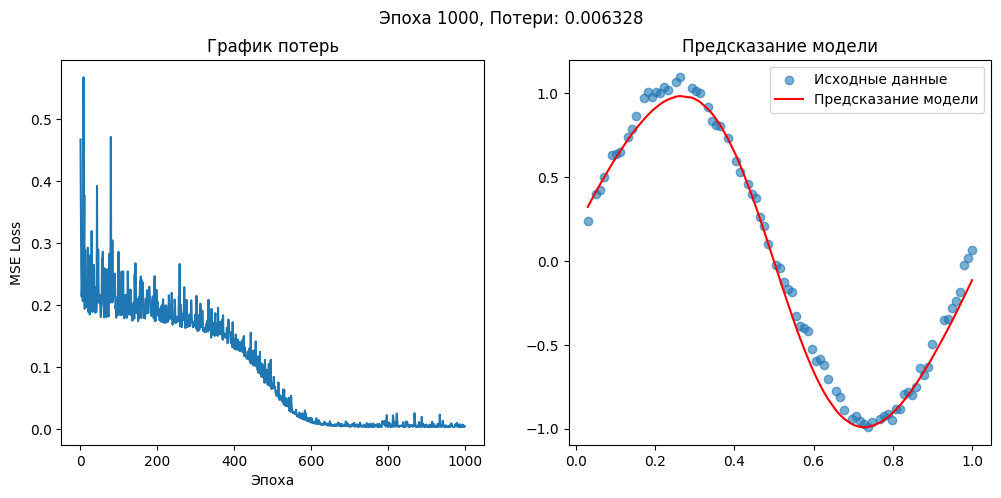

In [30]:
dset = TensorDataset(X_train,y_train)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = nn.Sequential(
    nn.Linear(X_train.shape[1],50),
    nn.Tanh(),
    nn.Linear(50, 1)
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.07)

EPOCHS = 1000
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch).flatten()
        loss = criterion(y_pred, y_batch.flatten())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
    #     print(f'epoch {epoch+1}, loss {e_loss}')
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("MSE Loss")

        ax2.scatter(X_train.numpy(), y_train.numpy(), label='Исходные данные', alpha=0.6)
        ax2.plot(X_train.numpy(), model(X_train).detach().numpy(), color='red', label='Предсказание модели')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {loss.item():.6f}")
        
        plt.show()

In [31]:
y_final = model(X_test)
for metric in [MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError,MeanSquaredLogError]:
    m = metric()
    if metric.__name__ == 'MeanSquaredLogError':
        
        print(f'{metric.__name__} = {m(y_final+1, y_test+1)}')
    else:
        print(f'{metric.__name__} = {m(y_final, y_test)}')

MeanAbsoluteError = 0.059621330350637436
MeanAbsolutePercentageError = 0.3634983003139496
MeanSquaredError = 0.005716735031455755
MeanSquaredLogError = 0.001972889993339777
